In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def replace_age_fraction(df_train):
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [5]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [6]:
replace_age_fraction(df_train)

0


In [7]:
replace_na_to_mode(df_train)

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [8]:
del(df_train['PassengerId'])
del(df_train['Name'])

In [9]:
import h2o
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 38 mins
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 6 days
H2O cluster name:,H2O_from_python_hamza_b5plzp
H2O cluster total nodes:,1
H2O cluster free memory:,4.788 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [10]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf_train.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


In [11]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [12]:
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=150,
                                      max_depth=5,
                                      min_rows=3,
                                      learn_rate=0.01,
                                      nfolds=7,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm")
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [13]:
def model_performance(model):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()



Train accuracy: 0.943460413855
valid accuracy: 0.894047224981


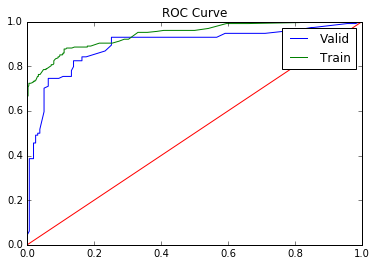

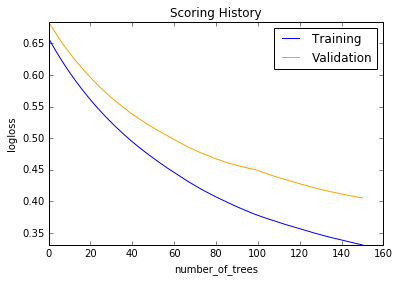

In [14]:
model_performance(my_gbm)
my_gbm.plot()

In [15]:
# Train naive bayse model
my_nb = H2ONaiveBayesEstimator(seed =1,
                               nfolds=15,
                               fold_assignment="Modulo",
                               keep_cross_validation_predictions=True,
                               model_id="my_nb")


my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.814524291498
valid accuracy: 0.806658942955


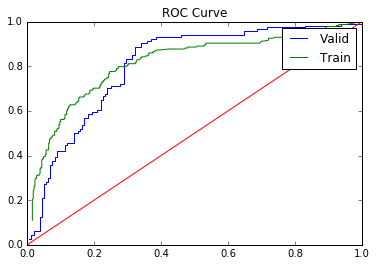

In [16]:
model_performance(my_nb)

In [17]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=500,
                                 nfolds=5,
                                 fold_assignment="AUTO",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.874066576698
valid accuracy: 0.901577843981


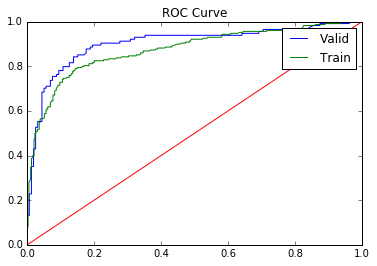

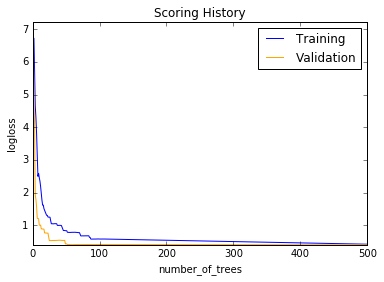

In [18]:
model_performance(my_rf)
my_rf.plot()

In [56]:
# train a deep learner model,10
my_dl = H2ODeepLearningEstimator(seed =10,
                                        hidden =[100,100,100,100,100,100,100],
                                        epochs =200,
                                        l2=1e-3, 
                                        model_id='my_dl',
                                        overwrite_with_best_model = False,
                                        rate = 0.5
                                       )
my_dl.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.927311066127
valid accuracy: 0.844091360477


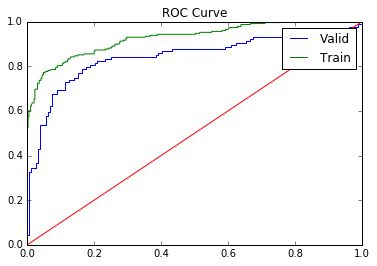

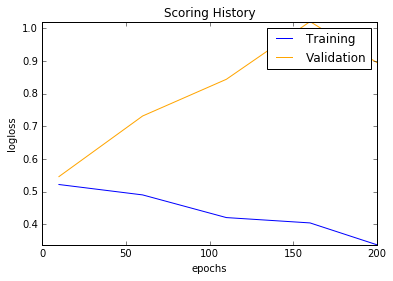

In [57]:
model_performance(my_dl)
my_dl.plot()

In [19]:
def get_level_one_data(base_model=[my_gbm, my_rf], response = 'Y', data = hdf_train, remove_response = False): 
    level_one_data= data[response]
    
    for i in base_model:
        level_one_data = level_one_data.cbind(i.predict(data))
    if(remove_response == False):
        return level_one_data
    elif(remove_response == True):
        level_one_data = level_one_data.drop(response)
        return level_one_data

In [20]:
def esemble_prediction(level_one_data, base_model=[my_gbm, my_rf], response = 'Y'):
    
    x = level_one_data.col_names
    x.remove(response)

    level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

    meta_learner.train(x = x, y = response, training_frame = level_one_data_test,
                       validation_frame=level_one_data_valid)


In [104]:
meta_learner = H2ODeepLearningEstimator(seed =10,
                                        hidden =[10,10],
                                        epochs =20,
                                        l2=1e-1, 
                                        model_id='dl10',
                                        overwrite_with_best_model = False,
                                        rate = 0.01
                                       )

In [105]:
# get_level_one_data(base_model=base_models, response= response)

In [106]:
base_models=[my_gbm, my_rf, my_nb, my_dl]
esemble_prediction(level_one_data=get_level_one_data(base_model=base_models, response= response),
                   base_model=base_models,response=response)

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.999631058546
valid accuracy: 0.999844599845


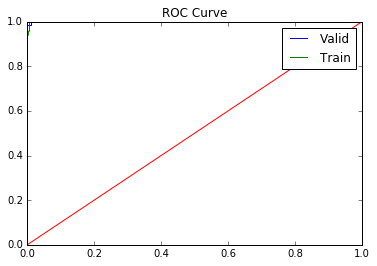

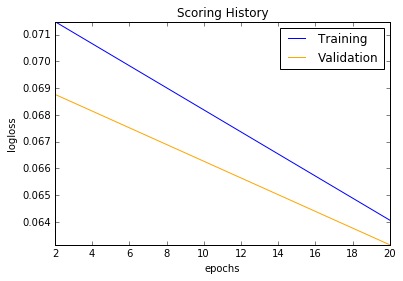

In [107]:
model_performance(meta_learner)
meta_learner.plot()

In [25]:
base_learner_prediction = get_level_one_data(base_model= base_models, data=hdf_validate, 
                                             response= response, remove_response= True)

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%


In [26]:
# base_learner_prediction

In [27]:
prediction= meta_learner.predict(base_learner_prediction)

deeplearning prediction progress: |███████████████████████████████████████| 100%


## Predict with Test Data



In [108]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

replace_age_fraction(df_test)
replace_na_to_mode(df_test)
# del(df_train['PassengerId'])
del(df_test['Name'])

0
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [109]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [110]:
def get_prediction(model, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [31]:
base_model_test_prediction = my_gbm.predict(hdf_test)
base_model_test_prediction = base_model_test_prediction.cbind(my_rf.predict(hdf_test))
base_model_test_prediction = base_model_test_prediction.cbind(my_nb.predict(hdf_test))

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%


In [32]:
df_submission = get_prediction(meta_learner,hdf_data=base_model_test_prediction)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [33]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)